In [2]:
import sys
!{sys.executable} -m pip install mediapipe opencv-python numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 9.1 MB/s eta 0:00:00

Analysis for test1.jpg:
  > Player Hands Detected: ['PAPER', 'SCISSORS']
  > Opponent Hands Detected: []
  > Status: Not enough hands detected for strategy.


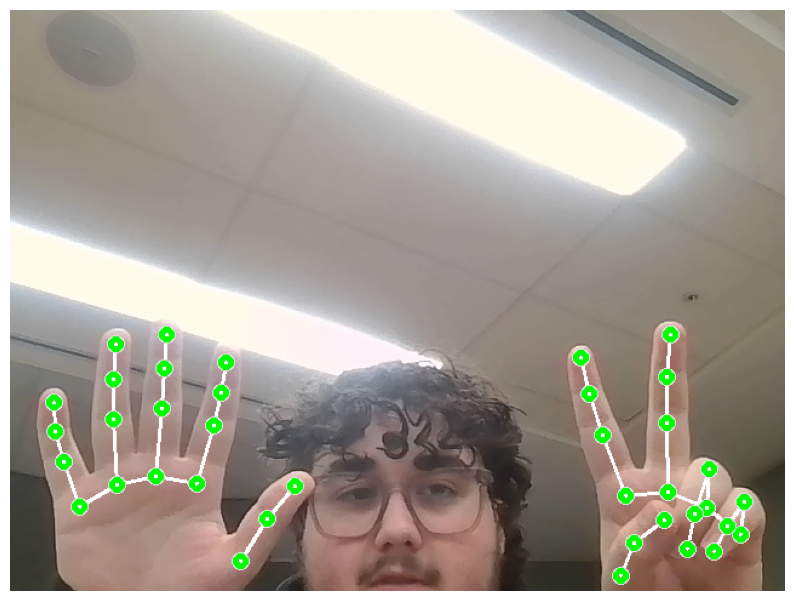

Error: Could not load test2.jpg
Error: Could not load test3.jpg
Error: Could not load test4.jpg
Error: Could not load test5.jpg


In [7]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

class HandShape(Enum):
    ROCK = 0
    PAPER = 1
    SCISSORS = 2
    UNKNOWN = -1

class GameStrategy:
    def __init__(self):
        self.rules = {
            (HandShape.ROCK, HandShape.SCISSORS): 1, (HandShape.ROCK, HandShape.PAPER): -1, (HandShape.ROCK, HandShape.ROCK): 0,
            (HandShape.PAPER, HandShape.ROCK): 1, (HandShape.PAPER, HandShape.SCISSORS): -1, (HandShape.PAPER, HandShape.PAPER): 0,
            (HandShape.SCISSORS, HandShape.PAPER): 1, (HandShape.SCISSORS, HandShape.ROCK): -1, (HandShape.SCISSORS, HandShape.SCISSORS): 0
        }
    def determine_winner(self, my_hand, opp_hand):
        return self.rules.get((my_hand, opp_hand), 0)

    def solve_nash(self, my_hands, opp_hands):
        # Nash Strategy Logic (Simplified for static image without history)
        score0 = self.determine_winner(my_hands[0], opp_hands[0]) + self.determine_winner(my_hands[0], opp_hands[1])
        score1 = self.determine_winner(my_hands[1], opp_hands[0]) + self.determine_winner(my_hands[1], opp_hands[1])
        rec = my_hands[0] if score0 >= score1 else my_hands[1]
        return rec, f"NASH: KEEP {rec.name}"

class HandDetector:
    def __init__(self):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=True,  # IMPORTANT: optimized for single images
            max_num_hands=4, 
            min_detection_confidence=0.1, # EXTREME SENSITIVITY (0.1)
            model_complexity=1
        )
        self.mp_draw = mp.solutions.drawing_utils

    def get_dist(self, p1, p2): return np.hypot(p1.x - p2.x, p1.y - p2.y)

    def classify_gesture(self, hand_landmarks):
        # Improved Logic for Static Images
        thumb = self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[4]) > self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[2])
        index = self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[8]) > self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[6])
        middle = self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[12]) > self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[10])
        ring = self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[16]) > self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[14])
        pinky = self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[20]) > self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[18])
        
        total = sum([thumb, index, middle, ring, pinky])
        
        # Aggressive Rock Detection
        if total <= 1: return HandShape.ROCK
        if index and middle and not ring and not pinky: return HandShape.SCISSORS
        if total >= 4: return HandShape.PAPER
        
        # Fallback for "Thumb-Out" Scissors
        if total == 3 and index and middle: return HandShape.SCISSORS
        
        return HandShape.UNKNOWN

    def process_static(self, image_path):
        img = cv2.imread(image_path)
        if img is None: return None, []
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = self.hands.process(img_rgb)
        detected = [] 
        
        if results.multi_hand_landmarks:
            for hand_lms in results.multi_hand_landmarks:
                y_pos = hand_lms.landmark[0].y
                shape = self.classify_gesture(hand_lms)
                detected.append((shape, y_pos))
                
                # Draw landmarks directly on image so you can see if it worked
                self.mp_draw.draw_landmarks(
                    img_rgb, 
                    hand_lms, 
                    self.mp_hands.HAND_CONNECTIONS,
                    self.mp_draw.DrawingSpec(color=(0, 255, 0), thickness=4, circle_radius=4),
                    self.mp_draw.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=2)
                )
                
        return img_rgb, detected
def analyze_sample_image(image_path):
    detector = HandDetector()
    strategy = GameStrategy()

    # Process Image
    img_rgb, raw_data = detector.process_static(image_path)
    if img_rgb is None:
        print(f"Error: Could not load {image_path}")
        return

    # Split Hands (Top vs Bottom)
    all_bottom = [d[0] for d in raw_data if d[1] > 0.5] # Player
    all_top = [d[0] for d in raw_data if d[1] <= 0.5]    # Opponent

    print(f"Analysis for {image_path}:")
    print(f"  > Player Hands Detected: {[h.name for h in all_bottom]}")
    print(f"  > Opponent Hands Detected: {[h.name for h in all_top]}")

    # Run Strategy
    if len(all_bottom) >= 2 and len(all_top) >= 2:
        rec_hand, reason = strategy.solve_nash(all_bottom[:2], all_top[:2])

        # Draw Result on Image
        h, w, _ = img_rgb.shape
        cv2.putText(img_rgb, f"ADVICE: {reason}", (50, h-50),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 4)
        print(f"  > AI Advice: {reason}")
    else:
        print("  > Status: Not enough hands detected for strategy.")

    # Show Image in Notebook
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

image_files = ["test1.jpg", "test2.jpg", "test3.jpg", "test4.jpg", "test5.jpg"]

for img_file in image_files:
    analyze_sample_image(img_file)

In [6]:
import cv2
import os
import glob
import time

def capture_training_data():
    # --- 1. CLEANUP PHASE ---
    # Find all files starting with "test" and ending in ".jpg"
    old_files = glob.glob("test*.jpg")
    for f in old_files:
        try:
            os.remove(f)
            print(f"Deleted old file: {f}")
        except Exception as e:
            print(f"Could not delete {f}: {e}")
            
    print("--- OLD DATA CLEARED ---")
    print("-" * 30)

    # --- 2. SETUP CAMERA ---
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    # Force 4:3 aspect ratio
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    print("--- IMAGE COLLECTION TOOL ---")
    print("Instructions:")
    print("1. Pose your hands (Top = Opponent, Bottom = You)")
    print("2. Press 's' to save the current frame.")
    print("3. Press 'q' to quit early.")
    print("-" * 30)
    
    current_image = 1
    max_images = 5
    
    while current_image <= max_images:
        ret, frame = cap.read()
        if not ret: break
        
        # Create UI copy
        ui = frame.copy()
        h, w, _ = frame.shape
        
        # Draw Guides
        cv2.line(ui, (0, h//2), (w, h//2), (0, 255, 255), 2)
        cv2.putText(ui, "OPPONENT (Top)", (20, h//2 - 20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        cv2.putText(ui, "PLAYER (Bottom)", (20, h//2 + 40), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        # Status Text
        cv2.putText(ui, f"Capture: {current_image}/5", (20, 50), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(ui, "Press 's' to Save", (20, 90), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200, 200, 200), 1)

        cv2.imshow("Data Collector", ui)
        
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            break
        elif key & 0xFF == ord('s'):
            # Save Clean Frame
            filename = f"test{current_image}.jpg"
            cv2.imwrite(filename, frame)
            print(f"[Saved] {filename}")
            
            # Flash Effect
            cv2.rectangle(ui, (0,0), (w,h), (255,255,255), -1)
            cv2.imshow("Data Collector", ui)
            cv2.waitKey(150)
            
            current_image += 1

    cap.release()
    cv2.destroyAllWindows()
    print("Collection Complete! 5 new images saved.")

if __name__ == "__main__":
    capture_training_data()

Deleted old file: test1.jpg
--- OLD DATA CLEARED ---
------------------------------
--- IMAGE COLLECTION TOOL ---
Instructions:
1. Pose your hands (Top = Opponent, Bottom = You)
2. Press 's' to save the current frame.
3. Press 'q' to quit early.
------------------------------
[Saved] test1.jpg
Collection Complete! 5 new images saved.
